# Source Code Analysis

## Initialization

In [1]:
import os
import sys

def add_path(path):
    if path not in sys.path:
        sys.path.insert(0, path)
        sys.path.append(path)
# add_path('/home/jjian03/anaconda3/lib/python3.7/site-packages')
# add_path(f'{os.path.abspath(os.path.join("."))}/lib')


### Load Data

In [2]:
import time, datetime, numpy as np, pandas as pd

seed = 77
np.random.seed(seed)

data_file = 'untrunc_data_cleaned_url.csv'

raw_data = pd.read_table(data_file, sep=',', index_col=0)
raw_data = raw_data.dropna()

raw_data.info()

print(f'raw_data: {raw_data.shape}')

<class 'pandas.core.frame.DataFrame'>
Int64Index: 58875 entries, 0 to 58911
Data columns (total 42 columns):
 #   Column                                  Non-Null Count  Dtype  
---  ------                                  --------------  -----  
 0   protocol_type                           58875 non-null  float64
 1   has_www                                 58875 non-null  float64
 2   has_iframe                              58875 non-null  float64
 3   int                                     58875 non-null  float64
 4   org                                     58875 non-null  float64
 5   gov                                     58875 non-null  float64
 6   in                                      58875 non-null  float64
 7   eu                                      58875 non-null  float64
 8   cn                                      58875 non-null  float64
 9   kr                                      58875 non-null  float64
 10  url_depth                               58875 non-null  fl

### Train Test Split

In [3]:
from sklearn.model_selection import train_test_split
from sklearn import preprocessing


x = raw_data
y = raw_data.label
y_scaler = preprocessing.StandardScaler()
y = y_scaler.fit_transform(y.values.reshape(-1, 1))
y = pd.DataFrame(y).iloc[:,0]


X_train_raw, X_test_raw, y_train, y_test = train_test_split(
    x, y, test_size = 0.33, random_state=seed)

X_train = X_train_raw.drop(['label', 'first_appear', 'url'], axis=1)
X_test = X_test_raw.drop(['label', 'first_appear', 'url'], axis=1)


In [4]:
import gc
import multiprocessing

import warnings
warnings.filterwarnings("ignore")


cpu_cnt = multiprocessing.cpu_count()
allocated_cpu = cpu_cnt
print(f"Allocated {allocated_cpu} CPUs")
gc.collect()

Allocated 16 CPUs


20

#### L-BFGS-B

In [5]:
from concurrent.futures.thread import ThreadPoolExecutor

from sklearn.model_selection import GridSearchCV

from Toolbox import ParameterGenerator
from tobit import *


start_time = time.time()

p_censor_left = -math.inf
p_censor_right = max(y)


param_tr = {
    'C': [round(i, 2) for i in np.arange(0, 70, 0.4).tolist()],
    'alpha': [.55, 1],
}

tr = TobitRegressor(
    p_censor_left=p_censor_left,
    p_censor_right=p_censor_right,
    C=49.8,
    alpha=1,
    verbose=True,
)

tr.fit(X_train, y_train)


      fun: 17918.27135185433
 hess_inv: <41x41 LbfgsInvHessProduct with dtype=float64>
      jac: array([-8.23377256e+00,  3.14493278e+01, -8.40393370e-01, -1.13238087e+01,
        9.52095976e+00, -2.55298004e-01,  2.70690815e+00,  5.64253671e+01,
        5.18508752e+01, -4.43221465e+01, -5.07738684e+01, -3.45887184e+00,
        2.00241038e-02,  1.35317508e+00, -4.38884492e+00,  1.36754962e+00,
       -2.31780396e+01,  7.07145786e+00,  1.79325114e+01,  2.08855966e+01,
        1.89570750e+01,  1.56369325e+01,  6.94822093e+00,  6.34989952e+00,
       -3.26293075e+01,  4.66239422e+01,  6.35926847e+01,  7.27634021e+01,
       -3.87309743e+01, -4.01852202e-01,  2.83143473e+01, -1.18607041e+00,
        1.37064684e-01,  2.66583806e+00,  1.13703432e+00, -5.98335301e+00,
       -9.88503164e+00, -1.26277565e+01, -1.77231629e+01,  3.47348876e+00,
        1.54603380e+01])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 174
      nit: 138
   status: 0
  success: True
      

TobitRegressor(C=49.8, alpha=1, p_censor_left=-inf,
               p_censor_right=0.2627393823832124, verbose=True)

### Predict

In [6]:
pred = tr.predict(X_test)
pred


43802    3.383479
25522    8.361410
32860    9.205688
5704     8.414685
18083    4.581168
           ...   
1449     5.044694
47108    9.298101
14000    6.215843
9537     8.092137
36986    8.670854
Length: 19429, dtype: float64

In [7]:
y_pred = y_scaler.inverse_transform(pred)
y_pred = y_pred + 1990

In [8]:
life_span = pd.Series(y_pred - X_test_raw.first_appear)
life_span.name = 'life_span'
urls = pd.merge(life_span, raw_data.url, how='inner',
         left_index=True, right_index=True)

raw_data = raw_data.drop('url', axis=1)
urls = pd.merge(urls, raw_data, how='inner',
         left_index=True, right_index=True)

urls.life_span

43802    15.123951
25522    19.892341
32860    21.549101
5704     21.996885
18083    13.474223
           ...    
1449     11.383818
47108    20.730447
14000    15.682011
9537     18.363936
36986    25.499575
Name: life_span, Length: 19429, dtype: float64

In [9]:
urls.loc[:, 'actual_life_span'] = urls.label + 1990 - urls.first_appear

In [10]:
from scipy import stats


urls.loc[:, 'is_gov'] = urls.gov == 1
urls_gov = urls[urls.gov == 1]
urls_others = urls[urls.gov != 1]


In [11]:
stats.ttest_ind(urls_gov.life_span, urls_others.life_span, equal_var = False)


Ttest_indResult(statistic=-7.725548745957733, pvalue=1.429935594631715e-14)

In [12]:
stats.ttest_ind(urls_gov.actual_life_span, urls_others.actual_life_span, equal_var = False)


Ttest_indResult(statistic=1.2499324708512984, pvalue=0.21140552615742766)

Text(0.5, 1.0, 'The predicted life span distribution of the websites')

<Figure size 432x288 with 0 Axes>

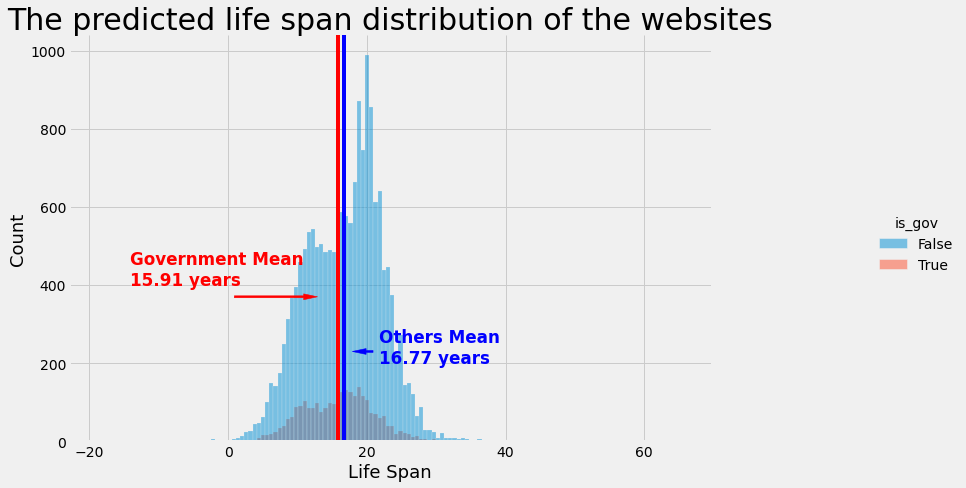

In [13]:
import matplotlib.pyplot as plt, matplotlib.style as style, seaborn as sns
from scipy.stats import norm
%matplotlib inline


plt.clf()
style.use('fivethirtyeight')
fig = sns.displot(urls, x="life_span", hue="is_gov")

fig.fig.set_size_inches(15,7)

plt.arrow(urls_gov.life_span.mean()-15, 370, 10, 0, width=5, head_length=2, color='red')
plt.axvline(urls_gov.life_span.mean(), 0, 10, c='red')
plt.text(urls_gov.life_span.mean()-30, 400, f'Government Mean\n{round(urls_gov.life_span.mean(), 2)} years', c='red', size='large', weight='bold')

plt.arrow(urls_gov.life_span.mean()+5, 230, -1, 0, width=5, head_length=2, color='blue')
plt.axvline(urls_others.life_span.mean(), 0, 10, c='blue')
plt.text(urls_others.life_span.mean()+5, 200, f'Others Mean\n{round(urls_others.life_span.mean(), 2)} years', c='blue', size='large', weight='bold')

plt.xlabel('Life Span', fontsize=18)
plt.ylabel('Count', fontsize=18)
plt.title('The predicted life span distribution of the websites', fontsize=30)


Text(0.5, 1.0, 'The actual life span distribution of the websites')

<Figure size 432x288 with 0 Axes>

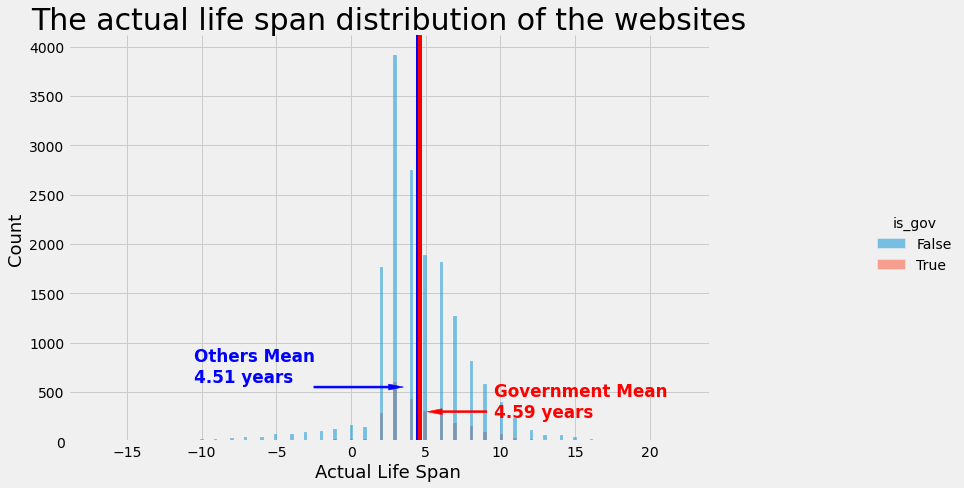

In [14]:
plt.clf()
style.use('fivethirtyeight')
fig = sns.displot(urls, x="actual_life_span", hue="is_gov")

fig.fig.set_size_inches(15,7)

plt.arrow(urls_others.actual_life_span.mean()-7, 550, 5, 0, width=20, head_length=1, color='blue')
plt.axvline(urls_others.actual_life_span.mean(), 0, 10, c='blue')
plt.text(urls_others.actual_life_span.mean()-15, 600, f'Others Mean\n{round(urls_others.actual_life_span.mean(), 2)} years', c='blue', size='large', weight='bold')

plt.arrow(urls_gov.actual_life_span.mean()+4.5, 300, -3, 0, width=20, head_length=1, color='red')
plt.axvline(urls_gov.actual_life_span.mean(), 0, 10, c='red')
plt.text(urls_gov.actual_life_span.mean()+5, 250, f'Government Mean\n{round(urls_gov.actual_life_span.mean(), 2)} years', c='red', size='large', weight='bold')

plt.xlabel('Actual Life Span', fontsize=18)
plt.ylabel('Count', fontsize=18)
plt.title('The actual life span distribution of the websites', fontsize=30)
